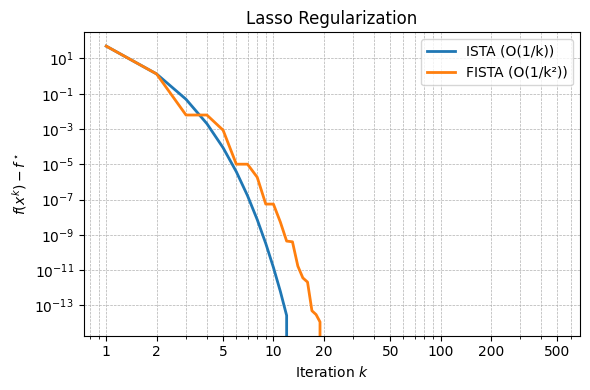

[LASSO] Skipped L-BFGS: L-BFGS only supports 'ridge' or 'elasticnet' (with alpha1 ≈ 0).


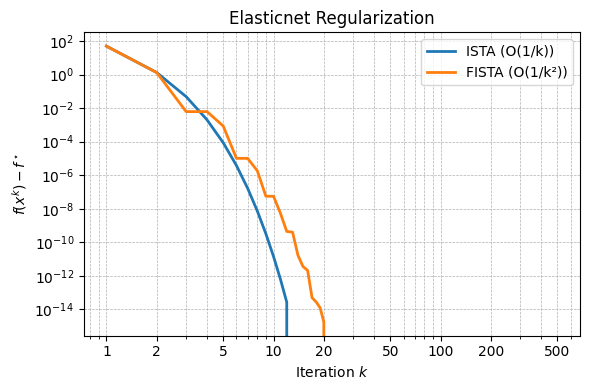

[ELASTICNET] Skipped L-BFGS: L-BFGS only supports smooth problems: alpha1 must be near 0.
[ELASTICNET] Skipped ISTA/FISTA: ISTA/FISTA not suitable for Elastic Net with alpha1 ≈ 0 (smooth-only). Use L-BFGS.
[RIDGE] Skipped ISTA/FISTA: ISTA not suitable for smooth-only problems like Ridge. Use L-BFGS instead.


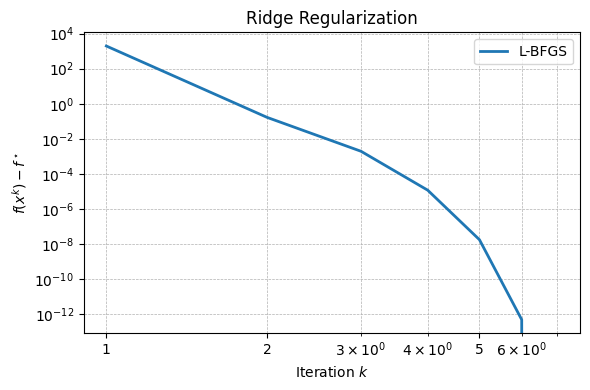

   method regularizer  n_iter    time_s   f_final  error_norm
0    ISTA       lasso     500  0.008595  4.620563    9.370669
1   FISTA       lasso     500  0.007728  4.620563    9.370669
2    ISTA  elasticnet     500  0.007326  5.635365    9.371018
3   FISTA  elasticnet     500  0.010276  5.635365    9.371018
4  L-BFGS  elasticnet       7  0.000638  5.013438    9.370899
5  L-BFGS       ridge       7  0.000661  5.013438    9.370899


In [8]:

# imports
from easy_boston_data import generate_easy_boston_like_data
from iterative_solvers import ista, fista
from lbfgs import LBFGSSolver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1) data gen + standardization
A, b, x_true = generate_easy_boston_like_data(m=800, seed=42, noise_std=0.1)
A_mean, A_std = A.mean(axis=0), A.std(axis=0)
A = (A - A_mean) / A_std
b = b - b.mean()

# 2) Lasso, Elastic-Net, Ridge
reg_settings = [
    {"name": "lasso",      "alpha1": 0.1, "alpha2": 0.0},
    {"name": "elasticnet", "alpha1": 0.1, "alpha2": 0.1},
    {"name": "elasticnet", "alpha1": 0.0, "alpha2": 0.1},
    {"name": "ridge",      "alpha1": 0.0, "alpha2": 0.1}
]

records = []

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    try:
        # ISTA
        t0 = time.perf_counter()
        x_ista, obj_ista = ista(A, b,
                                 reg_type=name,
                                 alpha1=a1,
                                 alpha2=a2,
                                 max_iter=500)
        t_ista = time.perf_counter() - t0

        # FISTA
        t0 = time.perf_counter()
        x_fista, obj_fista = fista(A, b,
                                   reg_type=name,
                                   alpha1=a1,
                                   alpha2=a2,
                                   max_iter=500)
        t_fista = time.perf_counter() - t0

        # approximate best f*
        f_star = obj_fista[-1]

        # --- compute the gaps (full length) ---
        gap_ista  = np.array(obj_ista)  - f_star
        gap_fista = np.array(obj_fista) - f_star

        # --- build envelope = running minimum (monotone decay) ---
        env_ista  = np.minimum.accumulate(gap_ista)
        env_fista = np.minimum.accumulate(gap_fista)

        # --- full iteration axis to max_iter (here 500) ---
        K = len(env_ista)
        ks = np.arange(1, K+1)

        # --- plot envelopes only, smooth lines, no markers ---
        fig, ax = plt.subplots(figsize=(6,4))
        ax.loglog(ks, env_ista,  '-', label="ISTA (O(1/k))", linewidth=2)
        ax.loglog(ks, env_fista, '-', label="FISTA (O(1/k²))", linewidth=2)

        ax.set_title(f"{name.title()} Regularization")
        ax.set_xlabel("Iteration $k$")
        ax.set_ylabel(r"$f(x^k)-f^\star$")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

        from matplotlib.ticker import LogLocator, FormatStrFormatter
        ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1,2,5]))
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1,10), numticks=12))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

        plt.tight_layout()
        plt.show()

        records.append({
            "method":      "ISTA",
            "regularizer": name,
            "n_iter":      len(obj_ista),
            "time_s":      t_ista,
            "f_final":     obj_ista[-1],
            "error_norm":  np.linalg.norm(x_ista - x_true)
        })
        records.append({
            "method":      "FISTA",
            "regularizer": name,
            "n_iter":      len(obj_fista),
            "time_s":      t_fista,
            "f_final":     obj_fista[-1],
            "error_norm":  np.linalg.norm(x_fista - x_true)
        })

    except ValueError as e:
        print(f"[{name.upper()}] Skipped ISTA/FISTA: {e}")

    # L-BFGS always attempted if valid
    try:
        solver = LBFGSSolver(reg_type=name, alpha1=a1, alpha2=a2)
        t0 = time.perf_counter()
        solver.fit(A, b)
        t_lbfgs = time.perf_counter() - t0

        records.append({
            "method":      "L-BFGS",
            "regularizer": name,
            "n_iter":      len(solver.history_),
            "time_s":      t_lbfgs,
            "f_final":     solver.final_obj_,
            "error_norm":  np.linalg.norm(solver.x_ - x_true)
        })

        # Plot convergence only for Ridge
        if name == "ridge":
            obj_vals = solver.history_
            f_star = solver.final_obj_
            gap_lbfgs = np.array(obj_vals) - f_star
            env_lbfgs = np.minimum.accumulate(gap_lbfgs)
            ks = np.arange(1, len(env_lbfgs)+1)

            fig, ax = plt.subplots(figsize=(6, 4))
            ax.loglog(ks, env_lbfgs, '-', label="L-BFGS", linewidth=2)
            ax.set_title("Ridge Regularization")
            ax.set_xlabel("Iteration $k$")
            ax.set_ylabel(r"$f(x^k)-f^\star$")
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            ax.legend()

            from matplotlib.ticker import LogLocator, FormatStrFormatter
            ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1,2,5]))
            ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1,10), numticks=12))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

            plt.tight_layout()
            plt.show()


    except ValueError as e:
        print(f"[{name.upper()}] Skipped L-BFGS: {e}")

# Final table
df_summary = pd.DataFrame(records)
print(df_summary)
